In [1]:
# imports
import os
import time

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import Conv2D, Dense, Flatten, MaxPool2D, InputLayer, Resizing, Rescaling, BatchNormalization
from keras import Sequential

In [2]:
# hyperparameters and data paths
DATA_FOLDER = '/kaggle/input/state-farm-distracted-driver-detection/imgs'
BATCH_SIZE = 32
RESIZED_WIDTH = 256
RESIZED_HEIGHT = 256

In [3]:
# train and val datasets with optional data augmentation
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_FOLDER, 'train'),
    #label_mode='categorical',
    validation_split=0.2,
    image_size=(480, 640),
    subset="both",
    seed=123,
    batch_size=BATCH_SIZE
)
#normalization_layer = tf.keras.layers.Rescaling(1./255)
#train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
#val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

Found 22424 files belonging to 10 classes.
Using 17940 files for training.
Using 4484 files for validation.


In [4]:
# create t4est data set and augmentation
#resized_layer = tf.keras.layers.Resizing(IMG_HEIGHT, IMG_WIDTH)
normalization_layer = tf.keras.layers.Rescaling(1./255)
def load(path):
    as_string = tf.io.read_file(path)
    as_image = tf.image.decode_image(as_string, channels=3)
    #resized = resized_layer(as_image)
    #normalized = tf.divide(resized, 255)
    #normalized = normalization_layer(resized)
    return as_image, path
test_folder = os.path.join(DATA_FOLDER, 'test')
test_files = os.listdir(test_folder)
test_files = [os.path.join(test_folder, fn) for fn in test_files]
test_ds = tf.data.Dataset.from_tensor_slices(test_files).map(load).batch(BATCH_SIZE)

In [5]:
# make sure datasets were loaded correctly
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

561
141
2492


In [6]:
# make sure datasets were loaded correctly
for img, _ in train_ds:
    print(img.shape)
    break
for img, _ in val_ds:
    print(img.shape)
    break
for img, _ in test_ds:
    print(img.shape)
    break

(32, 480, 640, 3)
(32, 480, 640, 3)
(32, 480, 640, 3)


In [7]:
# define architecture
# used for the custom CNNs
model = Sequential([
    #InputLayer((256, 256, 3)),
    #Resizing(RESIZED_HEIGHT, RESIZED_WIDTH),
    #Rescaling(1./255),
    #Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', padding='same'),
    #MaxPool2D(pool_size=(2, 2)),
    #Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', padding='same'),
    #BatchNormalization(),
    #MaxPool2D(pool_size=(2, 2)),
    #Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'),
    #MaxPool2D(pool_size=(2, 2)),
    #Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'),
    #BatchNormalization(),
    #MaxPool2D(pool_size=(2, 2)),
    #Conv2D(filters=128, kernel_size=3, strides=1, activation='relu', padding='same'),
    #MaxPool2D(pool_size=(2, 2)),
    #Flatten(),
    #Dense(units=512, activation='relu'),
    #Dense(units=128, activation='relu'),
    #Dense(units=10, activation='relu'),
    
    #InputLayer((480, 640, 3)),
    #Conv2D(filters=32, kernel_size=5, strides=1, activation='relu', padding='same'),
    #MaxPool2D(pool_size=(2, 2)), # (240, 320)
    #Conv2D(filters=64, kernel_size=5, strides=1, activation='relu', padding='same'),
    #MaxPool2D(pool_size=(2, 2)), # (120, 160)
    #Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'),
    #MaxPool2D(pool_size=(2, 2)), # (60, 80)
    #Conv2D(filters=128, kernel_size=3, strides=1, activation='relu', padding='same'),
    #MaxPool2D(pool_size=(2, 2)), # (30, 40)
    #Conv2D(filters=128, kernel_size=3, strides=1, activation='relu', padding='same'),
    #MaxPool2D(pool_size=(2, 2)), # (15, 20)
    #Conv2D(filters=256, kernel_size=3, strides=1, activation='relu', padding='same'),
    #MaxPool2D(pool_size=(2, 2)), # (7, 10)
    #Flatten(),
    #Dense(units=64, activation='relu'),
    #Dense(units=64, activation='relu'),
    #Dense(units=10, activation='softmax'), # number of classes
    
    InputLayer((480, 640, 3)),
    Conv2D(filters=32, kernel_size=5, strides=1, activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    
    Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    
    Conv2D(filters=128, kernel_size=3, strides=1, activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=3, strides=1, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(units=512, activation='relu'),
    Dense(units=128, activation='relu'),
    Dense(units=10, activation='softmax'), # number of classes
])

In [8]:
# define loss function
class LogLoss(tf.keras.losses.Loss):
  def __init__(self):
    super().__init__()
  def call(self, y_true, y_pred):
    loss_mult = tf.math.multiply(y_pred, y_true)
    loss_sum = tf.math.reduce_sum(loss_mult, 1)
    loss_log = tf.math.log(loss_sum)
    loss_mean = tf.math.reduce_mean(loss_log)
    loss_neg = tf.math.negative(loss_mean)
    return loss_neg

In [9]:
# build model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [10]:
# print architecture overview
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 480, 640, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 240, 320, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 240, 320, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 240, 320, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 120, 160, 32)     0         
 2D)                                                             
                                                        

In [11]:
# setup callbacks
checkpoint_path = "/kaggle/working/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
if not os.path.exists(checkpoint_dir):
  os.mkdir(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

In [12]:
# train model
epochs = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[cp_callback]
)

Epoch 1/100


/opt/conda/lib/python3.7/site-packages/keras/backend.py:5586: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits, "Softmax", "sparse_categorical_crossentropy"


561/561 [==============================] - ETA: 0s - loss: 0.6763 - accuracy: 0.8078
Epoch 1: saving model to /kaggle/working/training_1/cp.ckpt
561/561 [==============================] - 173s 286ms/step - loss: 0.6763 - accuracy: 0.8078 - val_loss: 0.2797 - val_accuracy: 0.9202
Epoch 2/100
561/561 [==============================] - ETA: 0s - loss: 0.0890 - accuracy: 0.9719
Epoch 2: saving model to /kaggle/working/training_1/cp.ckpt
561/561 [==============================] - 129s 229ms/step - loss: 0.0890 - accuracy: 0.9719 - val_loss: 0.1199 - val_accuracy: 0.9628
Epoch 3/100
561/561 [==============================] - ETA: 0s - loss: 0.0608 - accuracy: 0.9802
Epoch 3: saving model to /kaggle/working/training_1/cp.ckpt
561/561 [==============================] - 129s 229ms/step - loss: 0.0608 - accuracy: 0.9802 - val_loss: 0.0992 - val_accuracy: 0.9694
Epoch 4/100
561/561 [==============================] - ETA: 0s - loss: 0.0509 - accuracy: 0.9842
Epoch 4: saving model to /kaggle/workin

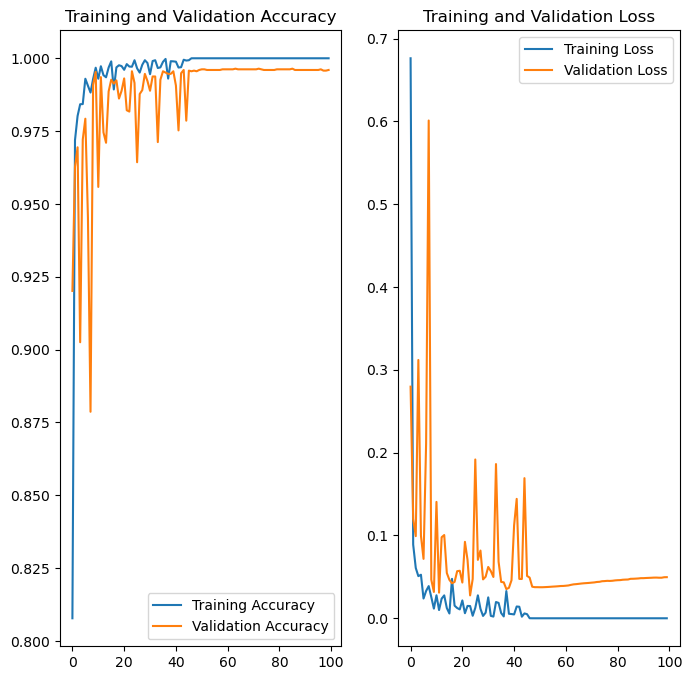

In [13]:
# plot accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
# predict on test set
predictions = np.array(['img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9'])
batch_count = 1
for (test, fn) in test_ds:
  if batch_count % 100 == 0:
    print('Batch', batch_count, '/', len(test_ds))
  batch_count += 1
  pred = model(test)

  fn = np.array(fn, dtype=np.str)
  pred = np.array(pred)
  fn = fn.reshape(-1, 1)
  data = np.concatenate((fn, pred), axis=1)
  for result in data:
    predictions = np.append(predictions, ','.join(result))

print(predictions.shape)
np.savetxt('/kaggle/working/submission.csv', predictions, fmt='%s')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == "__main__":


Batch 100 / 2492
Batch 200 / 2492
Batch 300 / 2492
Batch 400 / 2492
Batch 500 / 2492
Batch 600 / 2492
Batch 700 / 2492
Batch 800 / 2492
Batch 900 / 2492
Batch 1000 / 2492
Batch 1100 / 2492
Batch 1200 / 2492
Batch 1300 / 2492
Batch 1400 / 2492
Batch 1500 / 2492
Batch 1600 / 2492
Batch 1700 / 2492
Batch 1800 / 2492
Batch 1900 / 2492
Batch 2000 / 2492
Batch 2100 / 2492
Batch 2200 / 2492
Batch 2300 / 2492
Batch 2400 / 2492
(79727,)


In [15]:
# remove full file paths from submission file
from numpy import loadtxt
lines = loadtxt("/kaggle/working/submission.csv", delimiter="\n", unpack=False, dtype=np.str)
print(lines.shape)
for idx, val in enumerate(lines):
    lines[idx] = val.split('/')[-1]
np.savetxt('/kaggle/working/submission_postproc.csv', lines, fmt='%s')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


(79727,)
